쿠폰 사용 매출 / 쿠폰 미사용 매출

할인률 마다의 매출 비교

# 가설3: 쿠폰 설계 분석

- 쿠폰 지급 여부 및 할인율이 구매에 영향을 줄 것이다.
    - 3-1: 쿠폰 사용 매출이 비중이 더 높을 것이다.
        - 3-1-1: 쿠폰 할인율이 높을수록 매출이 증가할 것이다.

        → if True: 판매률이 저조한 상품들에 높은 할인율의 쿠폰을 제공한다.

        else 할인율이 낮더라도 쿠폰을 제공하여 매출 증대를 유도한다.

## 데이터로드

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 한글깨짐 해결
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [31]:
customer_df = pd.read_csv('archive\Customers_Data.csv')
discount_coupon_df = pd.read_csv('archive\Discount_Coupon.csv')
marketing_spend_df = pd.read_csv('archive\Marketing_Spend.csv')
online_sales_df = pd.read_csv('archive\Online_Sales_edit.csv')
tax_amount_df = pd.read_csv('archive\Tax_Amount.csv')

## 살펴볼 데이터
1. 총 매출
2. 쿠폰 적용 매출
3. 쿠폰 미적용 매출

In [32]:
online_sales_df
# discount_coupon_df

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used
...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,12/31/2019,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked
52920,14410,48494,12/31/2019,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used
52921,14410,48495,12/31/2019,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used
52922,14600,48496,12/31/2019,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked


## 전처리과정
1. 온라인 매출 - 쿠폰 - Tax → 병합
2. 매출액 컬럼 생성 → 매출액 = 평균가 * (1-GST) * 판매량 * (1-할인률) + 배송비
3. 쿠폰 적용유무별 총매출
4. 일자별 쿠폰 적용유무별 매출

#### 1. 온라인 매출 - 쿠폰 - Tax → 병합

In [33]:
# 필요한 컬럼만 추출
online_sales_df = online_sales_df[["Transaction_Date","Product_Category","Quantity","Avg_Price","Delivery_Charges","Coupon_Status"]]
# 병합을 위한 Month 컬럼 생성
format='%m/%d/%Y'
online_sales_df['Month'] = pd.to_datetime(online_sales_df['Transaction_Date'], format=format).dt.month_name().str.slice(stop=3)

# 불필요한 컬럼 제외
discount_coupon_df = discount_coupon_df.loc[:, discount_coupon_df.columns != 'Coupon_Code']

# Unique key를 위해 두 가지 컬럼을 기준으로 병합 - sales&coupon
merged = pd.merge(online_sales_df,discount_coupon_df,on=["Product_Category","Month"])
# 병합 - sales&coupon&tax
merged = pd.merge(merged,tax_amount_df,on=["Product_Category"])
merged


C:\Users\gzf05\AppData\Local\Temp\ipykernel_49040\284532940.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_sales_df['Month'] = pd.to_datetime(online_sales_df['Transaction_Date'], format=format).dt.month_name().str.slice(stop=3)


,Transaction_Date,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST
0,1/1/2019,Nest-USA,1,153.71,6.50,Used,Jan,10,10%
1,1/1/2019,Nest-USA,1,153.71,6.50,Used,Jan,10,10%
2,1/1/2019,Office,1,2.05,6.50,Used,Jan,10,10%
3,1/1/2019,Apparel,5,17.53,6.50,Not Used,Jan,10,18%
4,1/1/2019,Bags,1,16.50,6.50,Used,Jan,10,18%
...,...,...,...,...,...,...,...,...,...
52519,12/31/2019,Nest-USA,1,121.30,6.50,Clicked,Dec,30,10%
52520,12/31/2019,Apparel,1,48.92,6.50,Used,Dec,30,18%
52521,12/31/2019,Nest-USA,1,151.88,6.50,Used,Dec,30,10%
52522,12/31/2019,Nest-USA,5,80.52,6.50,Clicked,Dec,30,10%


#### 2. 매출액 컬럼 생성 → 매출액 = 평균가 * (1-GST) * 판매량 * (1-할인률) + 배송비

In [57]:
Avg_Price = merged['Avg_Price']
Quantity = merged['Quantity']
Delivery_Charges = merged['Delivery_Charges']
tax = merged['GST'].str.rstrip('%').astype(float)/100 # str → float
# Coupon_Status == 'Used'일 경우만 적용. 이외에는 0으로 치환하여 할인률 미적용
Discount_pct = np.where(merged['Coupon_Status'] == 'Used', merged['Discount_pct']/100, 0)
# 매출액 정의
sales_df = Avg_Price*(1-tax)*Quantity*(1-Discount_pct) + Delivery_Charges
# 매출액 컬럼 추가
merged['sales'] = sales_df

merged

,Transaction_Date,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST,sales
0,1/1/2019,Nest-USA,1,153.71,6.50,Used,Jan,10,10%,131.00510
1,1/1/2019,Nest-USA,1,153.71,6.50,Used,Jan,10,10%,131.00510
2,1/1/2019,Office,1,2.05,6.50,Used,Jan,10,10%,8.16050
3,1/1/2019,Apparel,5,17.53,6.50,Not Used,Jan,10,18%,78.37300
4,1/1/2019,Bags,1,16.50,6.50,Used,Jan,10,18%,18.67700
...,...,...,...,...,...,...,...,...,...,...
52519,12/31/2019,Nest-USA,1,121.30,6.50,Clicked,Dec,30,10%,115.67000
52520,12/31/2019,Apparel,1,48.92,6.50,Used,Dec,30,18%,34.58008
52521,12/31/2019,Nest-USA,1,151.88,6.50,Used,Dec,30,10%,102.18440
52522,12/31/2019,Nest-USA,5,80.52,6.50,Clicked,Dec,30,10%,368.84000


#### 3. 쿠폰 적용유무별 총매출

In [81]:
daily_coupon_used_df = merged.groupby(['Coupon_Status'])['sales'].sum().round(0).reset_index(name='sales') # 1의 자리까지 반올림

daily_coupon_used_df



,Coupon_Status,sales
0,Clicked,2385142.0
1,Not Used,729762.0
2,Used,1290972.0


#### 4. 일자별 쿠폰 적용유무별 매출

In [74]:
daily_coupon_used_df = merged.groupby(['Transaction_Date','Coupon_Status'])['sales'].sum().round(0).reset_index(name='sales') # 1의 자리까지 반올림

# Transaction_Date 컬럼을 날짜 형식으로 변환
daily_coupon_used_df['Transaction_Date'] = pd.to_datetime(daily_coupon_used_df['Transaction_Date'])
# 날짜로 정렬
daily_coupon_used_df = daily_coupon_used_df.sort_values(by='Transaction_Date')

daily_coupon_used_df.head(20)

,Transaction_Date,Coupon_Status,sales
0,2019-01-01,Clicked,3930.0
1,2019-01-01,Not Used,1224.0
2,2019-01-01,Used,2214.0
35,2019-01-02,Used,3524.0
34,2019-01-02,Not Used,2238.0
33,2019-01-02,Clicked,6626.0
68,2019-01-03,Used,7574.0
67,2019-01-03,Not Used,2985.0
66,2019-01-03,Clicked,13617.0
75,2019-01-04,Clicked,9470.0


In [73]:
# Pivot Table 생성
pivot_df = daily_coupon_used_df.pivot_table(index='Transaction_Date', 
                                            columns='Coupon_Status', 
                                            values='sales', 
                                            aggfunc='sum').reset_index()

Clicked = pivot_df['Clicked']
Not_used = pivot_df['Not Used']
Used = pivot_df['Used']
pivot_df['proportion_of_used_coupons'] = round(Used/(Clicked+Not_used+Used)*100,1)
pivot_df

Coupon_Status,Transaction_Date,Clicked,Not Used,Used,proportion_of_used_coupons
0,2019-01-01,3930.0,1224.0,2214.0,30.0
1,2019-01-02,6626.0,2238.0,3524.0,28.4
2,2019-01-03,13617.0,2985.0,7574.0,31.3
3,2019-01-04,9470.0,1993.0,4118.0,26.4
4,2019-01-05,9905.0,2612.0,4710.0,27.3
...,...,...,...,...,...
360,2019-12-27,7934.0,1384.0,2767.0,22.9
361,2019-12-28,5117.0,1416.0,3050.0,31.8
362,2019-12-29,5713.0,1490.0,3049.0,29.7
363,2019-12-30,3901.0,1723.0,1550.0,21.6


### 분석과정
1. 쿠폰 사용 매출이 비중이 더 높은지 확인 → 일자별 쿠폰 사용 매출 비중 확인

#### 1. 쿠폰 사용 매출이 비중이 더 높은지 확인 → 일자별 쿠폰 사용 매출 비중 확인

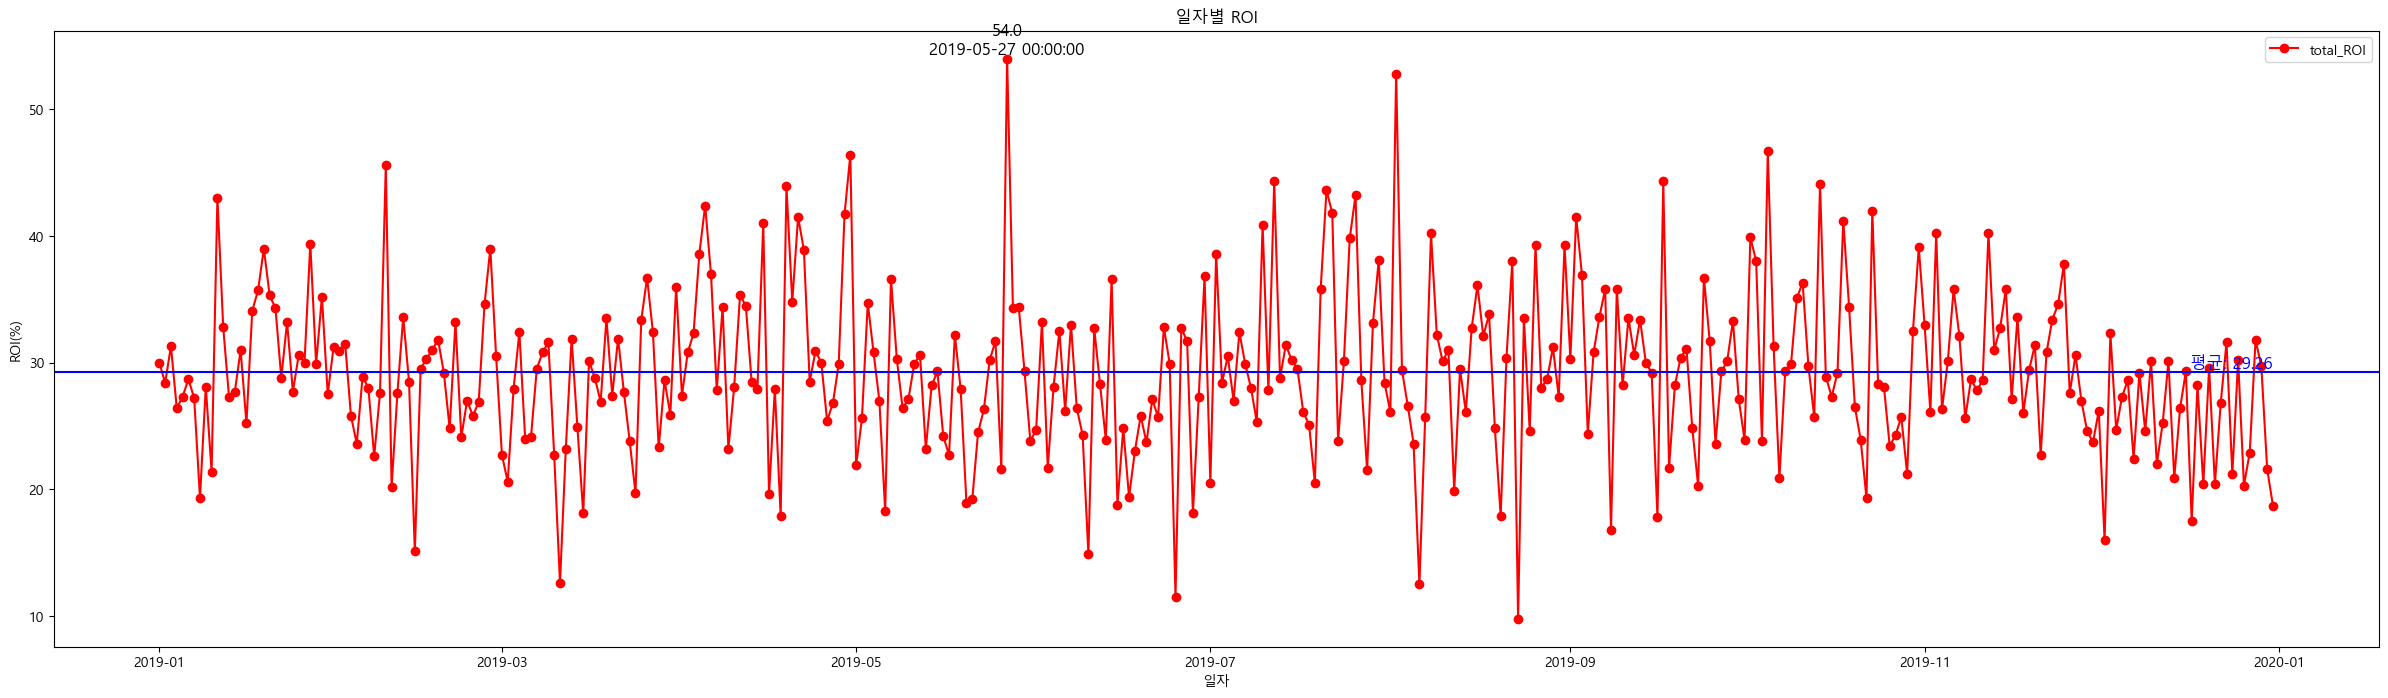

In [79]:
pivot_df
    # <일자별 ROI plot 그래프>

#그래프 크기 설정 
plt.figure(figsize=(30,8))

#일자별 ROI plot
plt.plot(pivot_df['Transaction_Date'],pivot_df['proportion_of_used_coupons'],color="red", label="total_ROI", marker='o')
# plt.plot(daily_ROI_df['Date'],daily_ROI_df['offline_ROI'],color="blue", label="offline_ROI")
# plt.plot(daily_ROI_df['Date'],daily_ROI_df['online_ROI'],color="green", label="online_ROI")

    # 데이터 포인트에 텍스트 추가
x,y = pivot_df['Transaction_Date'],pivot_df['proportion_of_used_coupons']


# 최대 값과 해당 인덱스 찾기
max_value = max(y)
max_index = y.argmax()

# 모든 데이터 포인트에 대해 반복하지 않고, 최대값에만 텍스트 추가
plt.text(x[max_index], y[max_index], f"{max_value}\n{x[max_index]}", ha='center', va='bottom', size=12)


# 평균값에 파란색 수평선 추가
plt.axhline(y=y.mean(), color='blue', linestyle='-')

# 수평선에 평균값 텍스트 추가
plt.text(x[len(x)-1], y.mean(), f"평균: {y.mean():.2f}", ha='right', va='bottom', size=12, color='blue')

#범례
plt.legend()

#그래프 타이틀
plt.title("일자별 ROI")

#x축 레이블
plt.xlabel('일자')

#y축 레이블 
plt.ylabel('ROI(%)')

#그래프 보여주기
plt.show()

### 결론
Q1. 쿠폰이 매출에 영향을 주는가?

    → 일자별 쿠폰 사용 매출 비중을 보았을 때, 평균 29.26% 로 매출 비중을 차지한다. 이것만으로는 쿠폰이 매출에 큰 영향을 준다고 보긴 어렵지만, Clicked를 쿠폰으로 인한 유입 매출이라고 본다면 54.14%를 차지하며, Used와 함께 83.43%의 매출을 차지한다.
    이를 통해 쿠폰의 적용 유무보다, 쿠폰의 존재 유무에 따라 매출이 증대한다고 추측해볼 수 있다.
    따라서 쿠폰의 할인율과 무관하게 작은 할인율의 쿠폰이라도 제공되는 것이 매출 증대를 위한 방안이라고 해석된다.